In [104]:
# importing libraries 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve,auc

import string
import re
import pickle
from textblob import TextBlob

import nltk 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [105]:
#loading the dataset 

true = pd.read_csv('/content/True.csv')
fake = pd.read_csv('/content/Fake.csv')

true["target"] = 0
fake["target"] = 1

df = pd.concat([true,fake])

df = shuffle(df)
df.head()

,title,text,subject,date,target
5110,U.S. high court action leaves transgender stud...,WASHINGTON (Reuters) - Transgender students at...,politicsNews,"March 6, 2017",0
12497,Brexit minister says agrees with EU negotiator...,LONDON (Reuters) - British Brexit minister Dav...,worldnews,"December 12, 2017",0
9715,HILLARY FINALLY Makes Statement On Sexual Pred...,"After several days of silence, Hillary Clinton...",politics,"Oct 10, 2017",1
20975,WHY MOM EMPLOYED BY DISNEY Is Calling Them “Bu...,"We can t say for sure, but we re guessing the ...",left-news,"Feb 19, 2016",1
14397,HOW REPUBLICAN LEADERS Are Willing To Sacrific...,Gut-wrenching behavior from a party who hasn t...,politics,"Feb 28, 2016",1


### Data Preprocessing and Cleaning 

In [106]:
df.shape

(44898, 5)

In [107]:
# Check for null values
df.isnull().sum() 

title      0
text       0
subject    0
date       0
target     0
dtype: int64

In [108]:
df['target'].value_counts() #dataset is balanced 

1    23481
0    21417
Name: target, dtype: int64

In [109]:
# Cleaning the data

def cleaning_data(text):
    # Lowercase the text
    text = text.lower()
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove any non-alphabetic tokens
    tokens = [token for token in tokens if token.isalpha()]
    
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join the filtered and lemmatized tokens into a string
    preprocessed_text = " ".join(tokens)
    return preprocessed_text


In [110]:
df['title'] = df['title'].apply(lambda x : cleaning_data(x))

In [111]:
df['text'] = df['text'].apply(lambda x : cleaning_data(x))

In [ ]:
df.head()

### EDA

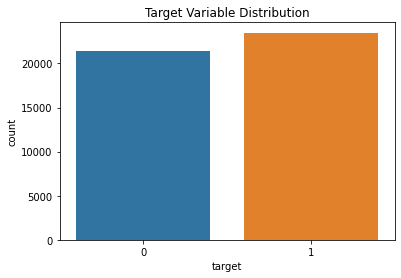

In [113]:
sns.countplot(x='target', data=df)
plt.title('Target Variable Distribution')
plt.show()

In [114]:
df['sentiment_polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
# df['sentiment_subjectivity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


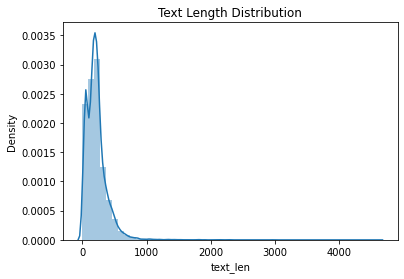

In [115]:
# Plot the distribution of text length
df['text_len'] = df['text'].apply(lambda x: len(x.split()))
sns.distplot(df['text_len'])
plt.title('Text Length Distribution')
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


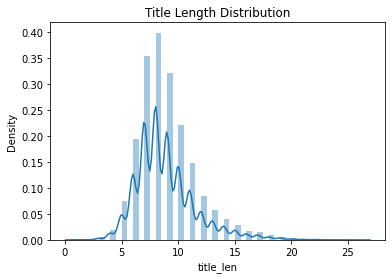

In [112]:
# Plot the distribution of title length
df['title_len'] = df['title'].apply(lambda x: len(x.split()))
sns.distplot(df['title_len'])
plt.title('Title Length Distribution')
plt.show()

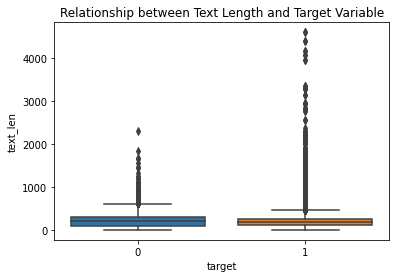

In [116]:
sns.boxplot(x='target', y='text_len', data=df)
plt.title('Relationship between Text Length and Target Variable')
plt.show()

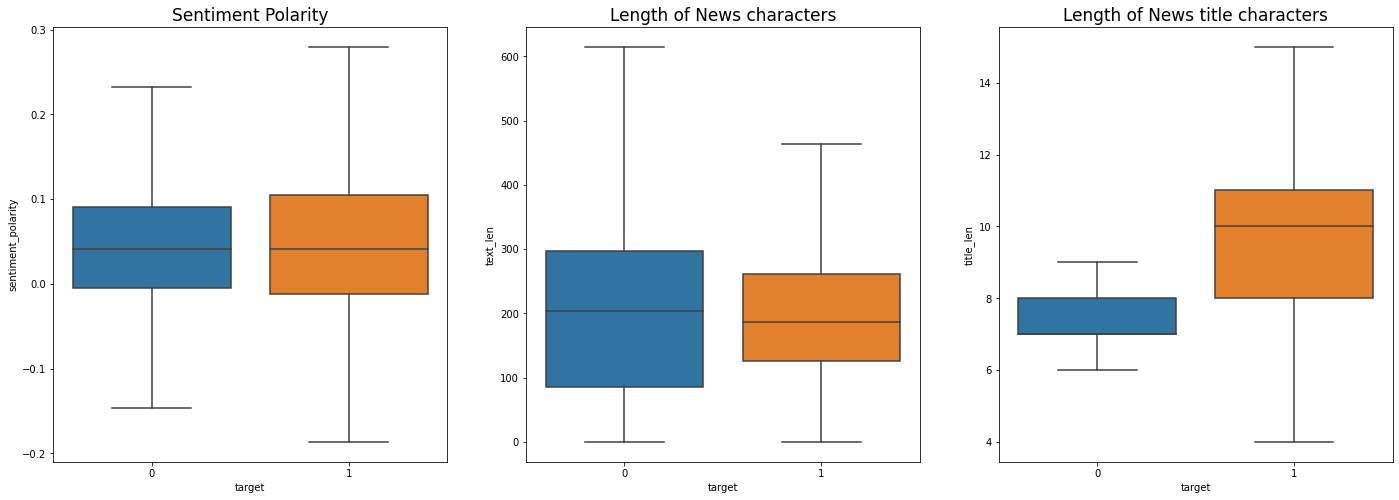

In [117]:
f, axes = plt.subplots(1, 3, figsize=(24,8))
sns.boxplot(y="sentiment_polarity", x= "target", data=df, orient='v', ax=axes[0], showfliers = False)
axes[0].set_title("Sentiment Polarity", fontsize=17)
sns.boxplot(y="text_len", x= "target", data=df, orient='v' , ax=axes[1], showfliers = False)
axes[1].set_title("Length of News characters", fontsize=17)
sns.boxplot(y="title_len", x= "target", data=df, orient='v' , ax=axes[2], showfliers = False)
axes[2].set_title("Length of News title characters", fontsize=17)
plt.show()

In [118]:
def ecdf(data):
 length= len(data)
 x = np.sort(data)
 y = np.arange(1, length+1)/length
 
 return x,y

def generate_hist_ECDF(data,x_label,title):
 x_1, y_1 = ecdf(data=data[df["target"] == 1])
 x_0, y_0 = ecdf(data=data[df["target"] == 0])
 
 fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
 fig.suptitle("ECDF and histogram plots for col — {} comparision between true and false".format(title))
 
 _ = ax1.plot(x_1, y_1, marker=".", linestyle="none")
 _ = ax1.plot(x_0, y_0, marker=".", linestyle="none")
 ax1.set(xlabel=x_label, ylabel="CDF")
 
 _ = ax2.hist(data[df["target"] == 1],density=True,bins=50)
 _ = ax2.hist(data[df["target"] == 0],density=True,bins=50)
 ax2.set(xlabel=x_label, ylabel="Probability Density")
 
 plt.legend()
 plt.show()

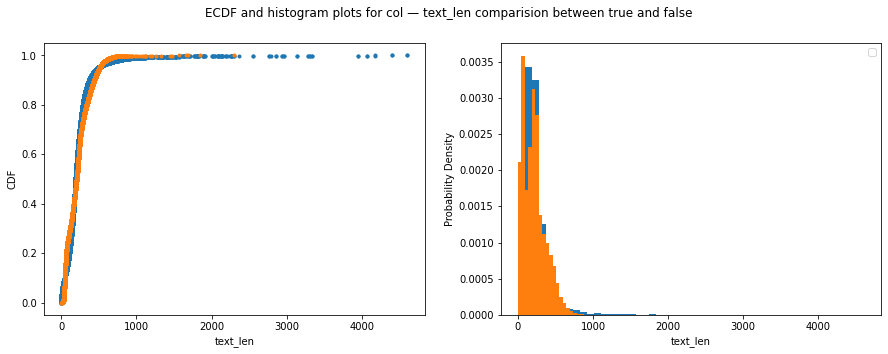

In [119]:
#Exploring differences in the length of news texts between true & fake news
generate_hist_ECDF(data=df["text_len"],x_label = "text_len", title="text_len")

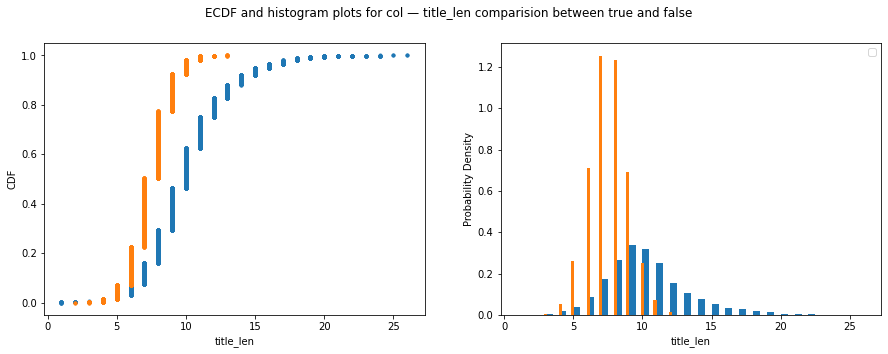

In [120]:
# Exploring differences in the length of news titles between true & fake news
generate_hist_ECDF(data=df["title_len"],x_label = "title_len", title="title_len")

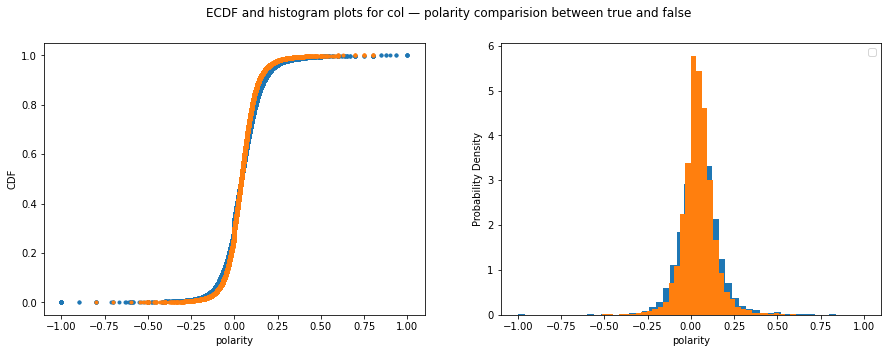

In [121]:
# Exploring differences in the sentiment polarity of news text between true & fake news
generate_hist_ECDF(data=df["sentiment_polarity"],x_label = "polarity", title="polarity")

In [122]:
def get_top_n_words(corpus, n=None):
 
 corpus_fake = corpus[df["target"] == 1].astype(str)
 corpus_true = corpus[df["target"] == 0].astype(str)
 
 vec = CountVectorizer(stop_words = 'english').fit(corpus_fake)
 bag_of_words = vec.transform(corpus_fake)
 sum_words = bag_of_words.sum(axis=0) 
 words_freq_fake = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
 words_freq_fake =sorted(words_freq_fake, key = lambda x: x[1], reverse=True)
 
 vec = CountVectorizer(stop_words = 'english').fit(corpus_true)
 bag_of_words = vec.transform(corpus_true)
 sum_words = bag_of_words.sum(axis=0) 
 words_freq_true = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
 words_freq_true =sorted(words_freq_true, key = lambda x: x[1], reverse=True)
 
 df_fake = pd.DataFrame(words_freq_fake[:n],columns = ["text", "count"])
 df_true = pd.DataFrame(words_freq_true[:n],columns = ["text", "count"])
 
 fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
 ax1.bar(df_fake["text"], df_fake["count"])
 ax1.set_xticklabels(df_fake["text"])
 ax1.set(xlabel="top 10 most frequent terms for fake news", ylabel="count")
 ax2.bar(df_true["text"], df_true["count"])
 ax2.set_xticklabels(df_true["text"])
 ax2.set(xlabel="top 10 most frequent terms for true news", ylabel="count")
 plt.suptitle("Comparision between the top 10 most frequent terms (fake/true)")
 
 plt.show()

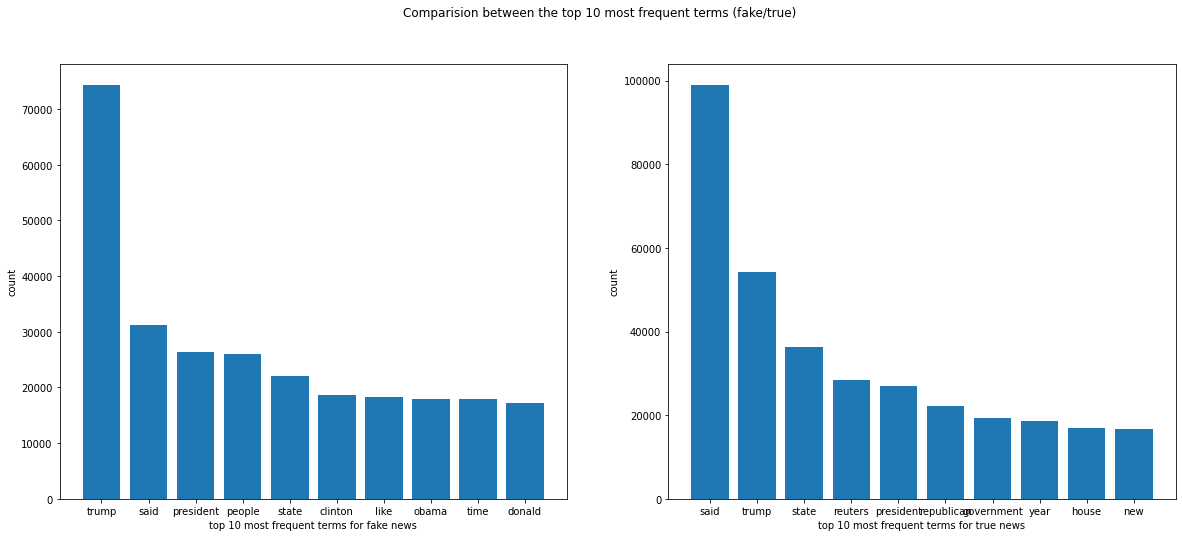

In [123]:
get_top_n_words(corpus=df["text"], n=10)

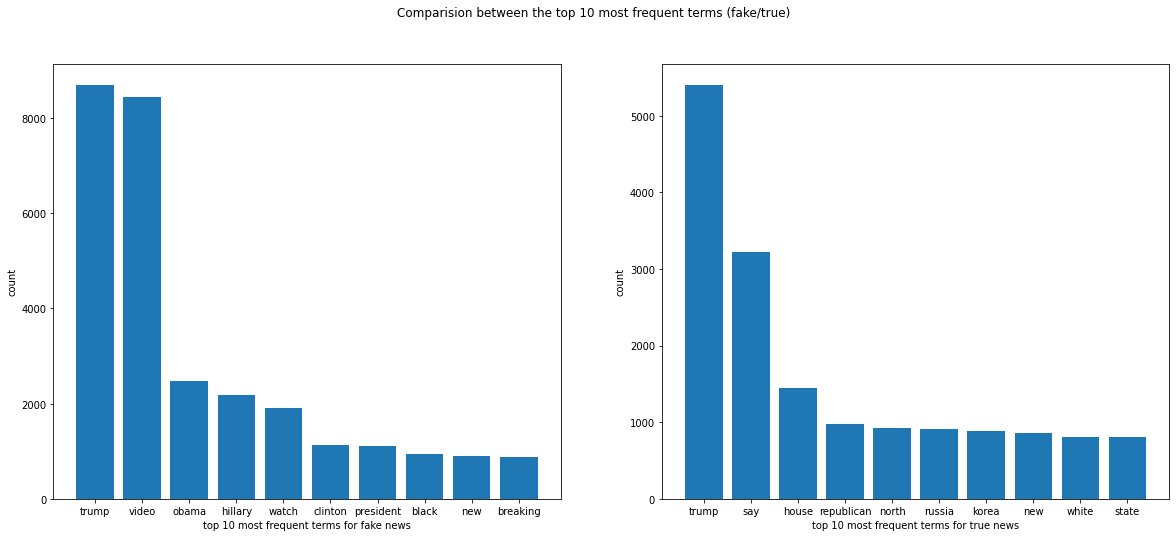

In [124]:
get_top_n_words(corpus=df["title"], n=10)

In [125]:
def get_top_n_bigram(corpus, n=None):
 
 corpus_fake = corpus[df["target"] == 1].astype(str)
 corpus_true = corpus[df["target"] == 0].astype(str)
 
 vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus_fake)
 bag_of_words = vec.transform(corpus_fake)
 sum_words = bag_of_words.sum(axis=0) 
 words_freq_fake = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
 words_freq_fake =sorted(words_freq_fake, key = lambda x: x[1], reverse=True)
 
 vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus_true)
 bag_of_words = vec.transform(corpus_true)
 sum_words = bag_of_words.sum(axis=0) 
 words_freq_true = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
 words_freq_true =sorted(words_freq_true, key = lambda x: x[1], reverse=True)
 
 df_fake = pd.DataFrame(words_freq_fake[:n],columns = ["text", "count"])
 df_true = pd.DataFrame(words_freq_true[:n],columns = ["text", "count"])
 
 fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
 ax1.bar(df_fake["text"], df_fake["count"])
 ax1.set_xticklabels(df_fake["text"])
 ax1.set(xlabel="top 10 most frequent terms for fake news", ylabel="count")
 ax2.bar(df_true["text"], df_true["count"])
 ax2.set_xticklabels(df_true["text"])
 ax2.set(xlabel="top 10 most frequent terms for true news", ylabel="count")
 plt.suptitle("Comparision between the top 10 most frequent terms (fake/true)")
 
 plt.show()

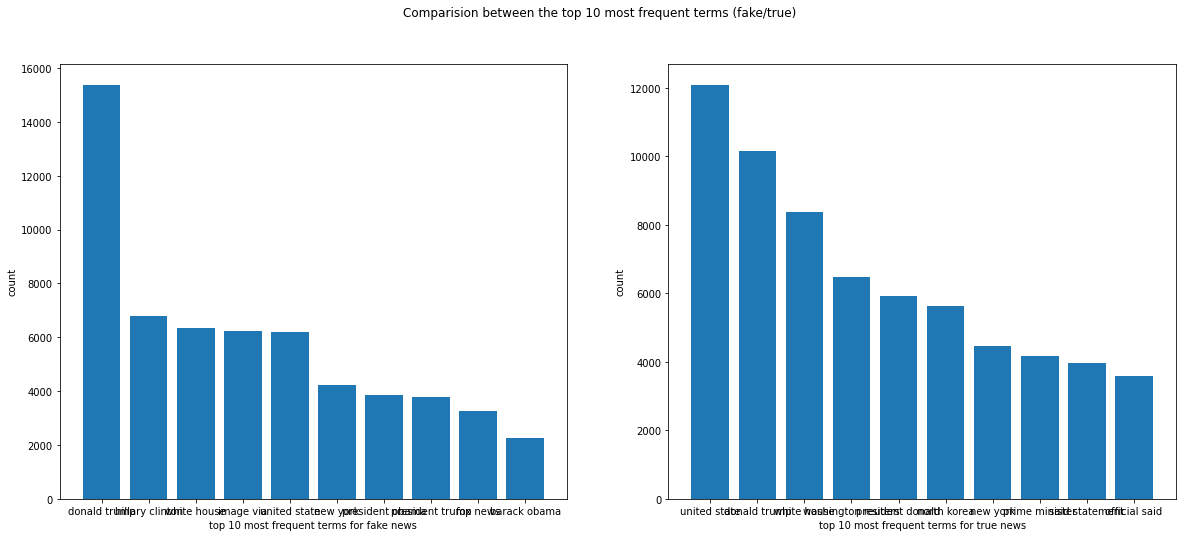

In [126]:
get_top_n_bigram(df['text'], n=10)

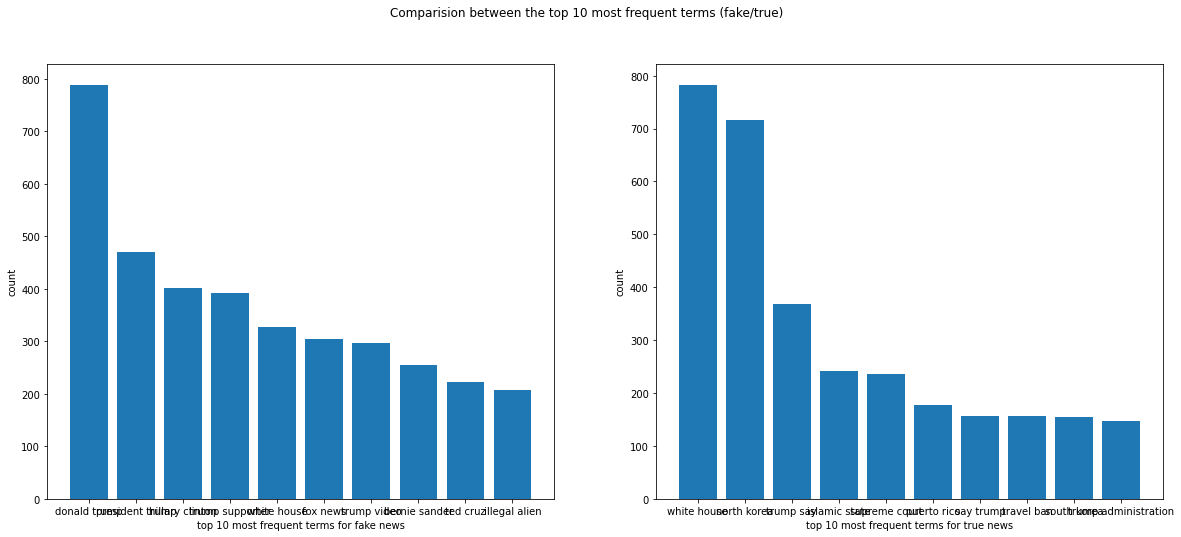

In [127]:
get_top_n_bigram(df['title'], n=10)

## Creating, training & evaluating 6 classifiers pipelines

In [128]:
def plot_con_matrix(classifier,X_test,y_test):
    class_names = df["target"].value_counts()
    np.set_printoptions(precision=2)
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", None)]
    
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
        disp.ax_.set_title(title)
        print(title)
        print(disp.confusion_matrix)

In [129]:
def load_up_classifier(classifier):
    x_train,x_test,y_train,y_test = train_test_split(df['text'], df["target"], test_size=0.25, random_state=2020)
    
    pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', classifier)])
    
    model = pipe.fit(x_train, y_train)
    prediction = model.predict(x_test)
    probs = model.predict_proba(x_test)
    
    plot_con_matrix(classifier=model,X_test=x_test,y_test=y_test)
    
    return model, probs, y_test, prediction

In [130]:
def calculate_metrics(model, prediction, y_test):
    # Calculate accuracy
    accuracy = accuracy_score(y_test, prediction)
    
    # Calculate F1 score
    f1 = f1_score(y_test, prediction, average='macro')
    
    # Calculate precision
    precision = precision_score(y_test, prediction, average='macro')
    
    # Calculate recall
    recall = recall_score(y_test, prediction, average='macro')
    
    results = {'Accuracy': accuracy, 'F1 score': f1, 'Precision': precision, 'Recall': recall}
    return results

In [131]:
def generate_roc_curve(model,y_test, probs, title):
    preds = probs[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic - {}'.format(title))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Logistic Regression

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion matrix, without normalization
[[5273  101]
 [ 108 5743]]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Normalized confusion matrix
[[5273  101]
 [ 108 5743]]


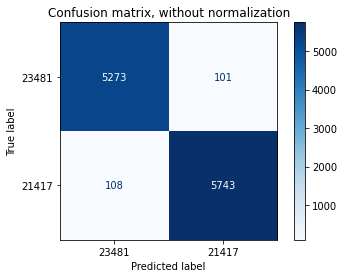

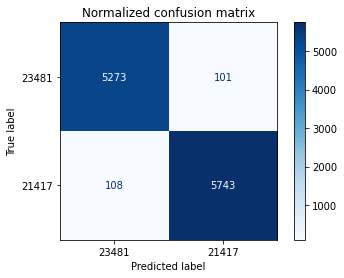

In [132]:
model_LR, probs, y_test, prediction = load_up_classifier(classifier=LogisticRegression())

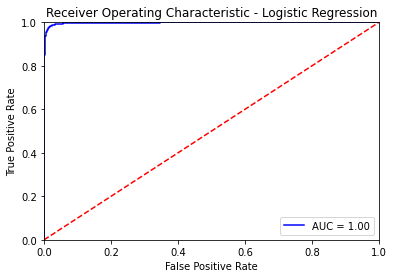

In [133]:
generate_roc_curve(model=model_LR,y_test=y_test, probs=probs, title="Logistic Regression")

In [134]:
calculate_metrics(model = model_LR, prediction = prediction, y_test = y_test)

{'Accuracy': 0.9813808463251671,
 'F1 score': 0.9813481465315654,
 'Precision': 0.9813233490310738,
 'Recall': 0.9813737112744685}

### Multinomial NB

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion matrix, without normalization
[[4978  396]
 [ 353 5498]]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Normalized confusion matrix
[[4978  396]
 [ 353 5498]]


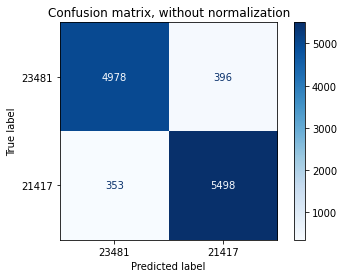

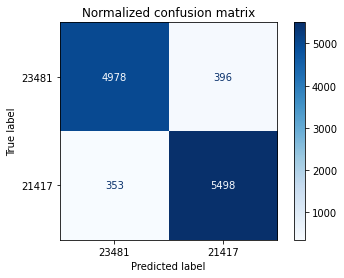

In [135]:
model_MNB, probs, y_test, prediction = load_up_classifier(classifier=MultinomialNB())

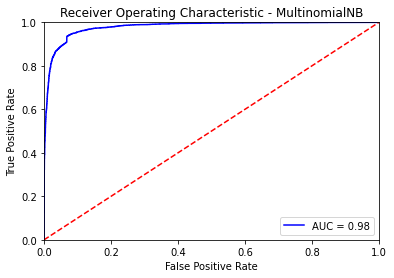

In [136]:
generate_roc_curve(model=model_MNB,y_test=y_test, probs=probs, title="MultinomialNB")

In [137]:
calculate_metrics(model = model_MNB, prediction = prediction, y_test = y_test)

{'Accuracy': 0.9332739420935412,
 'F1 score': 0.9331304386037644,
 'Precision': 0.9332982802473537,
 'Recall': 0.9329901523613604}

### Bernoulli NB

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion matrix, without normalization
[[5184  190]
 [ 203 5648]]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Normalized confusion matrix
[[5184  190]
 [ 203 5648]]


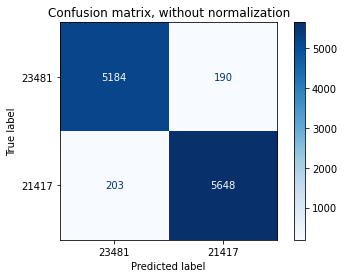

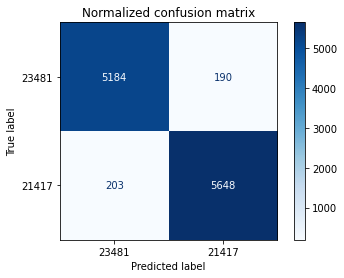

In [138]:
model_BNB, probs, y_test, prediction = load_up_classifier(classifier=BernoulliNB())

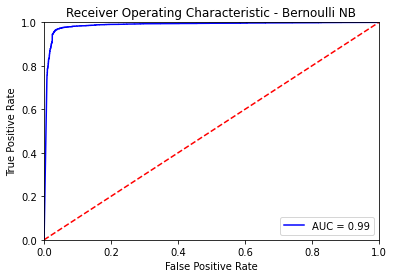

In [139]:
generate_roc_curve(model=model_BNB,y_test=y_test, probs=probs, title="Bernoulli NB")

In [140]:
calculate_metrics(model = model_BNB, prediction = prediction, y_test = y_test)

{'Accuracy': 0.9649888641425389,
 'F1 score': 0.9649289385727966,
 'Precision': 0.96488564803306,
 'Recall': 0.9649748305472261}

### Gradient Boosent

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion matrix, without normalization
[[5362   12]
 [  47 5804]]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Normalized confusion matrix
[[5362   12]
 [  47 5804]]


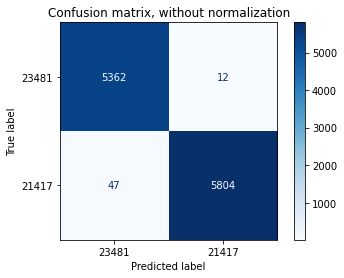

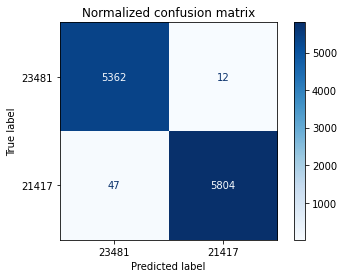

In [141]:
model_GBC, probs, y_test, prediction = load_up_classifier(classifier=GradientBoostingClassifier())

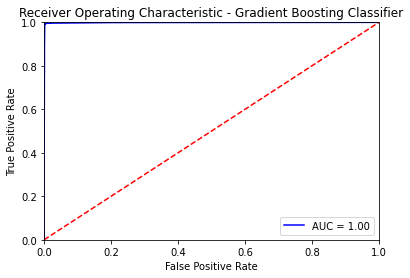

In [142]:
generate_roc_curve(model=model_GBC,y_test=y_test, probs=probs, title="Gradient Boosting Classifier")

In [143]:
calculate_metrics(model = model_GBC, prediction = prediction, y_test = y_test)

{'Accuracy': 0.9947438752783965,
 'F1 score': 0.9947357130001105,
 'Precision': 0.9946237523023805,
 'Recall': 0.9948671057600427}

### Decision Tree

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion matrix, without normalization
[[5351   23]
 [  29 5822]]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Normalized confusion matrix
[[5351   23]
 [  29 5822]]


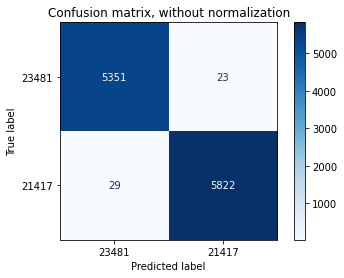

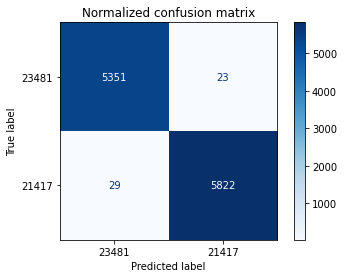

In [144]:
model_DT, probs, y_test, prediction = load_up_classifier(classifier=DecisionTreeClassifier())

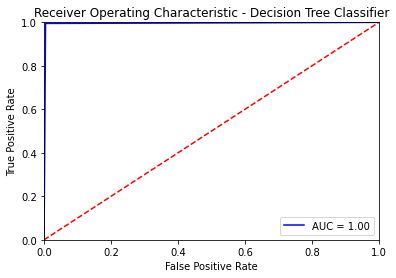

In [145]:
generate_roc_curve(model=model_DT,y_test=y_test, probs=probs, title="Decision Tree Classifier")

In [146]:
calculate_metrics(model = model_DT, prediction = prediction, y_test = y_test)

{'Accuracy': 0.9953674832962138,
 'F1 score': 0.9953593127438726,
 'Precision': 0.9953373391294946,
 'Recall': 0.9953818581360199}

### Random Forest Classifier

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion matrix, without normalization
[[5314   60]
 [  83 5768]]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Normalized confusion matrix
[[5314   60]
 [  83 5768]]


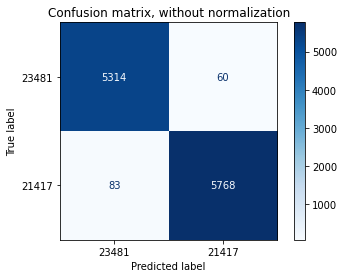

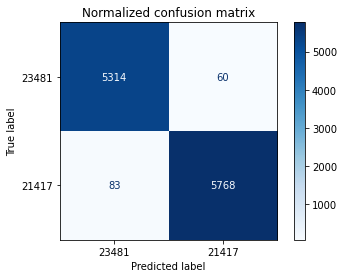

In [147]:
model_RFC, probs, y_test, prediction = load_up_classifier(classifier=RandomForestClassifier())

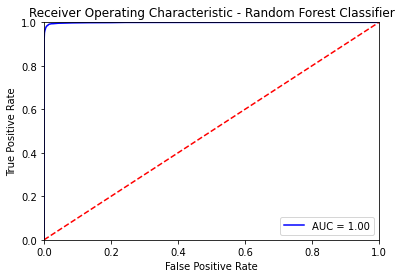

In [148]:
generate_roc_curve(model=model_RFC,y_test=y_test, probs=probs, title="Random Forest Classifier")

In [149]:
calculate_metrics(model = model_RFC, prediction = prediction, y_test = y_test)

{'Accuracy': 0.987260579064588,
 'F1 score': 0.9872397053515269,
 'Precision': 0.9871629794075842,
 'Recall': 0.9873247614100237}

In [157]:
pickle.dump(model_GBC,open('model_GBC.pkl','wb'))
pickle.dump(model_LR,open('model_LR.pkl','wb'))
pickle.dump(model_DT,open('model_DT.pkl','wb'))
pickle.dump(model_RFC,open('model_RFC.pkl','wb'))
pickle.dump(model_BNB,open('model_BNB.pkl','wb'))
pickle.dump(model_MNB,open('model_MNB.pkl','wb'))